In [13]:
import math
import pandas as pd
import numpy as np

# Para este notebook solo
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

In [8]:
file_path = './clinicaltrials_citations.csv'
df= pd.read_csv(file_path)
# Filtrar el DataFrame para incluir solo las filas donde "CitedBy" no es nulo
df = df[df["CitedBy"].notna()].copy()

In [9]:
# Convertir cada valor string a un array de números
df['CitedBy'] = df['CitedBy'].dropna().apply(lambda x: [int(num) for num in x.split(', ')])

# Eliminar el primer elemento de cada lista en la columna 'CitedBy'
df['CitedBy'] = df['CitedBy'].apply(lambda x: x[2:] if len(x) > 0 else x)

# Convertir a int los PMIDs
df['ReferencePMID'] = df['ReferencePMID'].dropna().apply(lambda x: int(x))

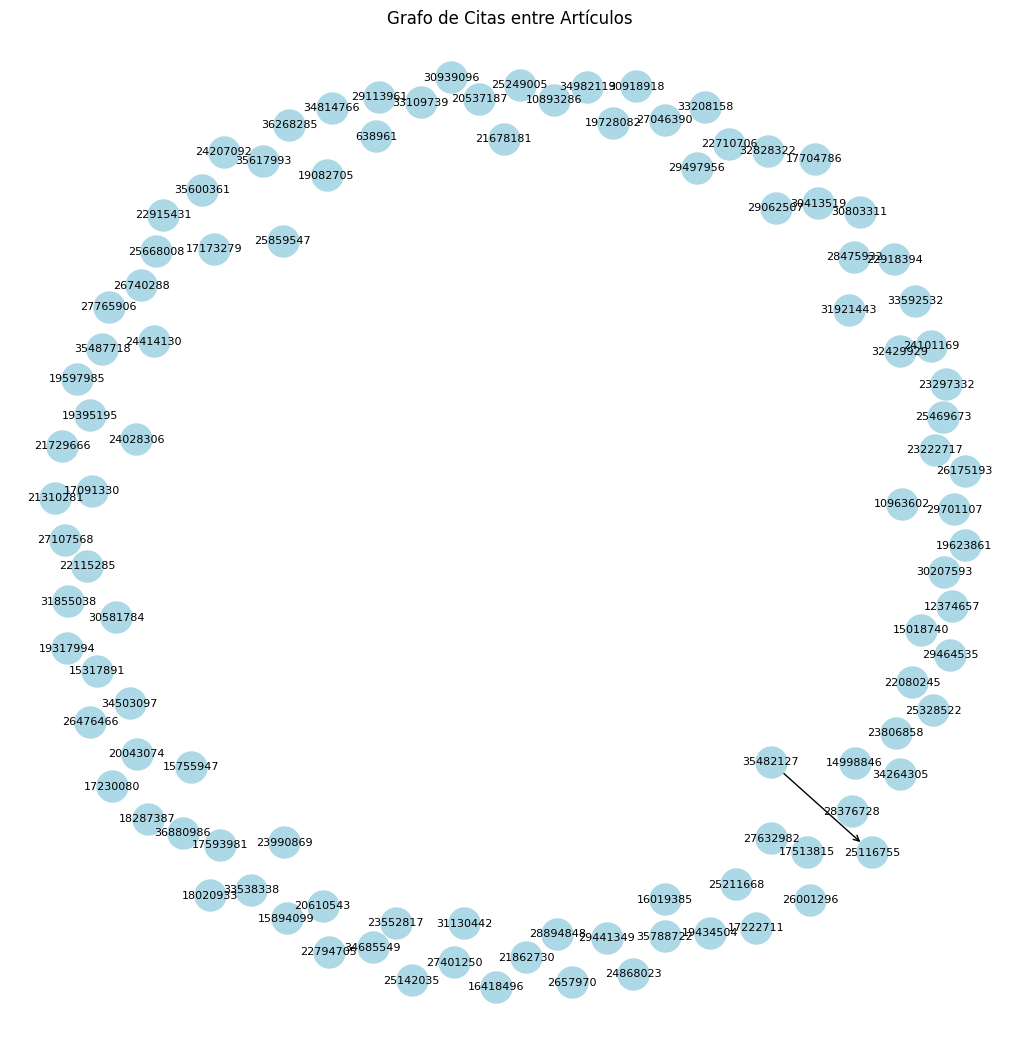

In [10]:
# Crear un grafo direccional
G = nx.DiGraph()

# Añadir nodos (artículos) al grafo
for pmid in df['ReferencePMID']:
    G.add_node(pmid)

# Añadir aristas al grafo
for idx, row in df.iterrows():
    pmid = int(row['ReferencePMID'])
    cited_by = row['CitedBy']
    for citation in cited_by:
        # Añadir la arista solo si el artículo citado también está en ReferencePMID
        if citation in df['ReferencePMID'].values:
            G.add_edge(citation, pmid)

# Dibujar el grafo
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color='lightblue', font_size=8, node_size=500, arrowstyle='->', arrowsize=10)
plt.title('Grafo de Citas entre Artículos')
plt.show()


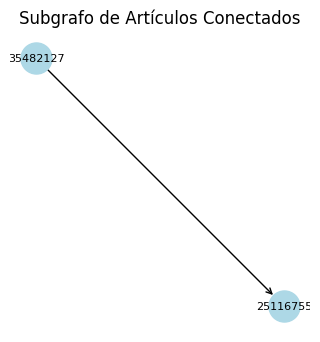

In [11]:
# Crear un subgrafo con solo los nodos que tienen aristas (conectados)
subgrafo = G.subgraph([n for n in G if G.degree(n) > 0])

# Dibujar el subgrafo
plt.figure(figsize=(3, 3))
nx.draw(subgrafo, with_labels=True, node_color='lightblue', font_size=8, node_size=500, arrowstyle='->', arrowsize=10)
plt.title('Subgrafo de Artículos Conectados')
plt.show()

In [12]:
file_path = './clinicaltrials_temas.csv'
df= pd.read_csv(file_path)
# Filtrar el DataFrame para incluir solo las filas donde "Temas" no es nulo
df = df[df["Temas"].notna()].copy()

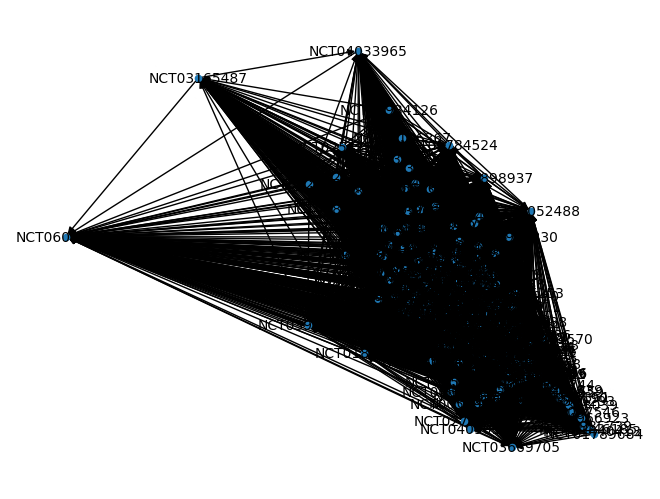

In [14]:


# Convertir 'StartDate' a formato de fecha
# df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce', format='%B %d, %Y')

# Crear un diccionario de NCTId a temas y fecha de inicio
nctid_to_info = df.set_index('NCTId').to_dict('index')

# Inicializar un grafo dirigido
G = nx.DiGraph()

# Añadir nodos con NCTId como identificador y atributos de temas y fecha
for nctid, info in nctid_to_info.items():
    G.add_node(nctid, temas=info['Temas'], start_date=info['StartDate'])

# Añadir aristas dirigidas
for nctid1, info1 in nctid_to_info.items():
    for nctid2, info2 in nctid_to_info.items():
        if nctid1 != nctid2 and set(info1['Temas']).intersection(info2['Temas']) and info1['StartDate'] < info2['StartDate']:
            G.add_edge(nctid1, nctid2)

# Visualizar el grafo
nx.draw(G, with_labels=True, node_size=20, font_size=10)

# Guardar el grafo
# nx.write_graphml(G, "tu_grafo.graphml")



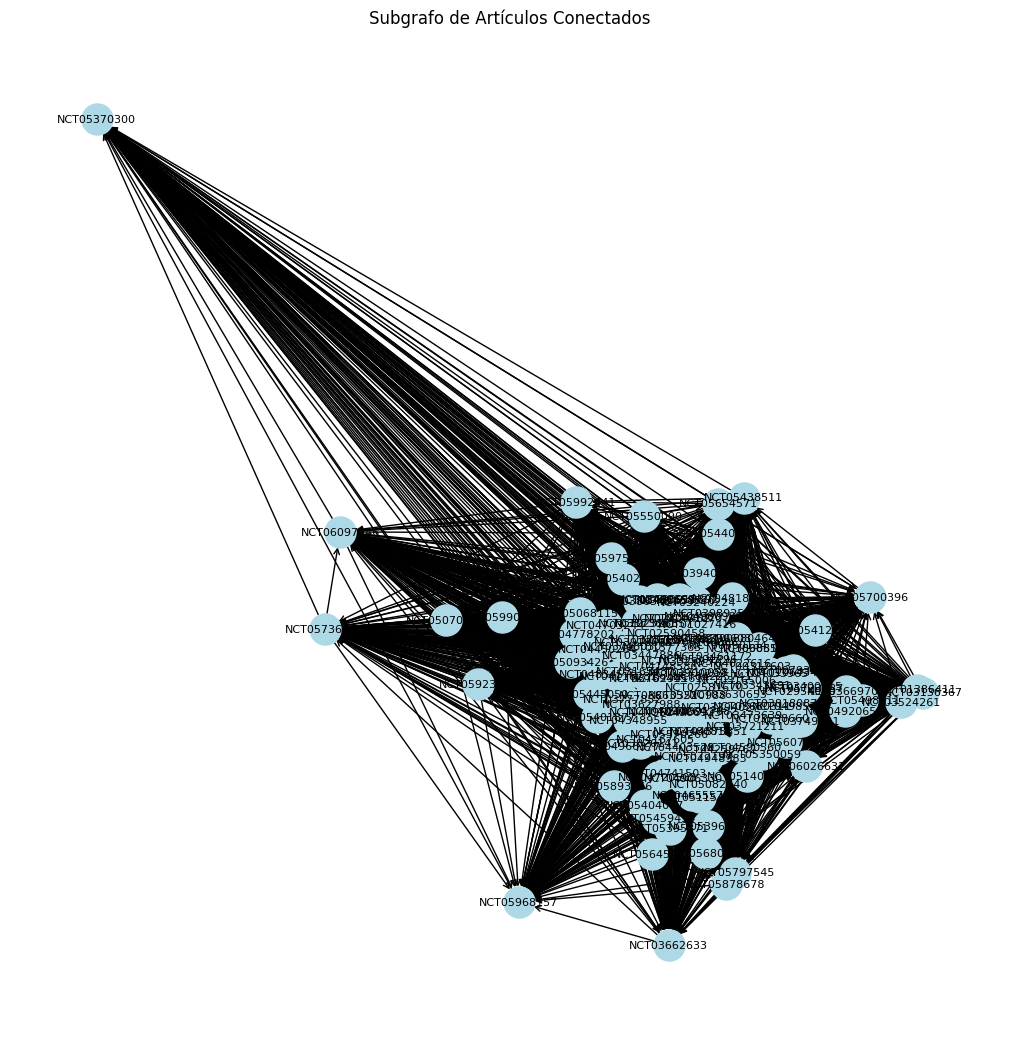

In [ ]:
# Crear un subgrafo con solo los nodos que tienen aristas (conectados)
G = G.subgraph([n for n in G if G.degree(n) > 0])

# Dibujar el subgrafo
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color='lightblue', font_size=8, node_size=500, arrowstyle='->', arrowsize=10)
plt.title('Subgrafo de Artículos Conectados')
plt.show()

<ipython-input-54-00d01c1e2ff2>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label='Centralidad de Grado')


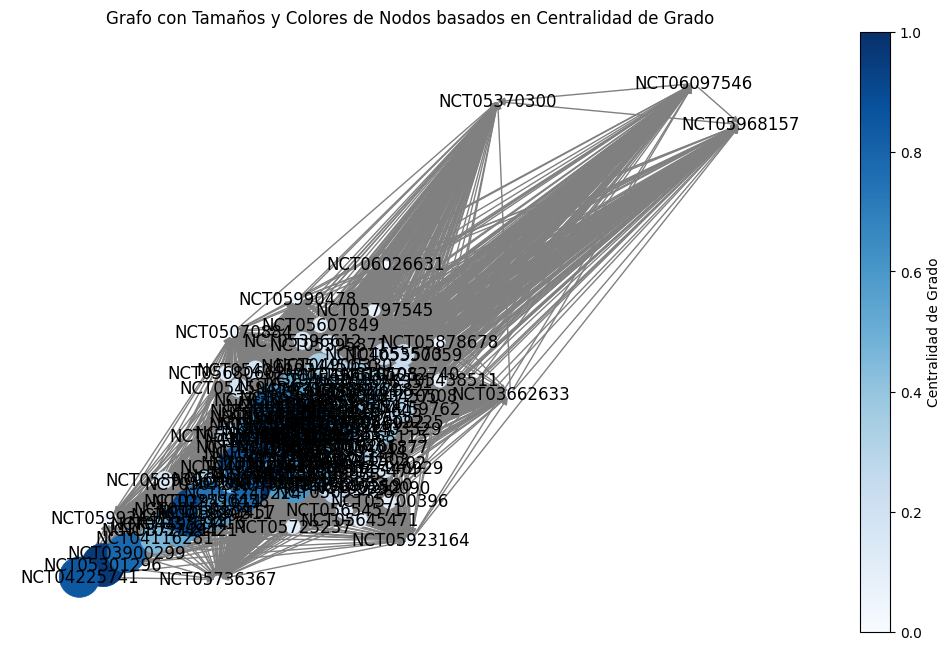

In [ ]:

# Calcular la centralidad de grado saliente
out_degree_centrality = nx.out_degree_centrality(G)

# Calcular tamaños de nodos basados en la centralidad de grado saliente
node_sizes_out = [out_degree_centrality[node] * 1000 for node in G.nodes()]

node_colors_out = [out_degree_centrality[node] for node in G.nodes()]
max_color = max(node_colors_out)
min_color = min(node_colors_out)
node_colors_out = [(x - min_color) / (max_color - min_color) for x in node_colors_out]  # Normalizar


# Dibujar el grafo
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_size=node_sizes_out,
        node_color=node_colors_out, cmap=plt.cm.Blues,
        edge_color="gray", linewidths=0.5, with_labels=False)
plt.title("Grafo con Tamaños y Colores de Nodos basados en Centralidad de Grado")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label='Centralidad de Grado')
plt.show()



In [ ]:
import pandas as pd

# Convertir los diccionarios de centralidad a DataFrames
df_in_degree = pd.DataFrame(sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True), columns=['Nodo Entrante', 'Centralidad de Grado'])
df_out_degree = pd.DataFrame(sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True), columns=['Nodo Saliente', 'Centralidad de Grado'])

# Tomar los 5 primeros nodos para cada tipo de centralidad
top_5_in_degree = df_in_degree.head(5)
top_5_out_degree = df_out_degree.head(5)

# Definir una función para aplicar estilos a los DataFrames
def aplicar_estilo(df):
    return df.style.set_table_styles(
        [{'selector': 'th',
          'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-weight', 'bold'), ('color', 'black'), ('background-color', 'lightgrey')]},
         {'selector': 'td',
          'props': [('text-align', 'left'), ('font-size', '11pt')]}]
    ).hide_index()

# Aplicar estilos y mostrar las tablas
display(aplicar_estilo(top_5_in_degree))

display(aplicar_estilo(top_5_out_degree))


<ipython-input-52-e10b0f41b418>:18: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  ).hide_index()


Nodo Entrante,Centralidad de Grado
NCT05370300,1.000000
NCT05968157,0.992248
NCT06097546,0.984496
NCT05736367,0.976744
NCT06026631,0.968992


Nodo Saliente,Centralidad de Grado
NCT03390608,1.000000
NCT04033965,0.992248
NCT03669705,0.984496
NCT05301296,0.961240
NCT00880464,0.961240
